In [74]:
import numpy as np
import pandas as pd
import time
from datetime import datetime,timedelta
import json
import re

In [75]:
#根据log_index，增量读取log内容
def load_log(file_name, log_index):
    log_value_list = list()
    date_list = list()
    try:
        with open(file_name,'rb') as f:
            for index,content in enumerate(f):
                if index == log_index:
                    log_data = json.loads(content.decode('utf8'))
                    log_data['@timestamp'] = str(datetime.strptime(log_data['@timestamp'][0:19],'%Y-%m-%dT%H:%M:%S'))
                    log_value_list.append(log_data)
                    date_list.append(log_data['@timestamp'])
                    log_index += 1
    except Exception as e:
        print(e)
    #将文本内容转化为pandas的dataframe
    temp_log = pd.DataFrame(log_value_list, index=date_list)
    return  temp_log,log_index

In [76]:
#移动时间窗口，返回时间范围内新增的数据
def load_log_by_interval(all_log, time_windows, time_index):
    start_time = str(time_index)
    end_date = time_index + timedelta(seconds=time_windows) #根据时间窗口计算结束时间
    end_time = str(end_date)
    return all_log[start_time: end_time]
    

In [77]:
#根据正则表达式匹配字符串，reg：正则，check_str：待匹配字符串， 返回True，False
def reg_check(reg, check_str):
    result = re.search(reg,check_str,re.M|re.I) #正则表达式匹配
    if result:
        return True
    else:
        return False

In [88]:
#判断用户的操作类型（SQL注入、非支付平台访问、爬虫访问等不合法的网络入侵行为），生成一个用户行为矩阵并记录好用户的ip地址，ip地址使用user_op_list[x]["sip"]
'''
    每一列代表的意义（某时间窗内）：
    1.正常访问次数
    2.SQL注入
    3.非支付平台访问
    4.爬虫爬取
    5.不合理URI请求（请求非.do .js .css .html .jpg .png的地址）
    6.恶意挂马
'''
def cerate_one_hot_encodeing(temp_log_data):
    
    '''
        定义正则表达式匹配相关内容
    '''
    trojan_reg = r'<script(.+?)/script>|<style(.+?)/style>|<[^>]*>' #匹配request中嵌入的html，js，css,php代码   其他挂马暂时不知如何匹配
    pay_flatform_reg = r'Ali+|MicroMessenger|MQQBrowser' #^((?!XXX).)*$
    spider_reg = r'spiderman|Go-http-client'
    sql_reg = r'/(\%27)|(\')|(\-\-)|(\%23)|(#)/ix|/((\%3D)|(=))[^\n]*((\%27)|(\')|(\-\-)|(\%3B)|(:))/i|/\w*((\%27)|(\'))((\%6F)|o|(\%4F))((\%72)|r|(\%52))/ix|/((\%27)|(\'))union/ix(\%27)|(\')' #正则表达式匹配SQL语句
    illegal_url_reg = r'/.*\.(?:(?!(do|jpg|png|html|js|css)).)+/ ' #匹配除了.do .jpg .png .html .js .css之外的扩展名

    ip_list = list()
    req_list = list()
    temp_matrix = list()
    
    length =  len(temp_log_data.index)
    
    for x in range(0, length):
        if x+1 == length:
            break
        data = temp_log_data[x:x+1]
        #初始化各类初值，0-》无 1-》有1次某一次行为
        normal_visited, sql_flag, pay_flatform, spider, illegal_url, trojan = 0, 0, 0, 0, 0, 0 #对应的是正常访问，sql注入，非支付平台，爬虫，非合理url，挂马
        
        if reg_check(spider_reg, data["ua"].values[0]):
            spider = 1
        if reg_check(trojan_reg, data["request"].values[0]):
            trojan = 1
        if reg_check(illegal_url_reg, data["request"].values[0]):
            illegal_url = 1
        if not reg_check(pay_flatform_reg, data["ua"].values[0]) and spider==0:
            pay_flatform = 1
        if reg_check(sql_reg, data["request"].values[0]):
            sql_flag = 1
        
        if spider == 0 and trojan == 0 and illegal_url == 0 and pay_flatform == 0 and sql_flag == 0:
            normal_visited = 1
        
        #将全部ip 全部向量放入列表
        ip_list.append(str(data["sip"].values[0]))
        req_list.append(str(data["request"].values[0]))
        temp_matrix.append(np.array([normal_visited, sql_flag, pay_flatform, spider, illegal_url, trojan], dtype=int))
        
    return ip_list, np.array(temp_matrix,dtype=int), req_list

In [89]:
# 得到时间窗口内所有ip操作矩阵的重复ip下标
def get_multiplicity_ip(ip_list):
    multiplicity_ip_dict = dict()
    for index,value in enumerate(ip_list):
        if value not in multiplicity_ip_dict.keys():
            multiplicity_ip_dict[value] = list()
        multiplicity_ip_dict[value].append(index)
    return multiplicity_ip_dict

In [90]:
#将得到的某1分钟数据合并并追加至总的矩阵中，返回总矩阵、ip_dict和ip_reserve_dict
def merge_vector(temp_matrix, multiplicity_ip_dict, ip_dict, ip_reserve_list, all_matrix):
    for ip in multiplicity_ip_dict.keys():
        index = int(all_matrix.shape[0])
        number = np.array([0,0,0,0,0,0], dtype=int)
        for ip_index in multiplicity_ip_dict[ip]:
            number += temp_matrix[ip_index]
        all_matrix = np.concatenate((all_matrix,np.array([number],dtype=int)), axis=0)
        
        ip_reserve_list.append(ip)
        if ip not in ip_dict.keys():
            ip_dict[ip] = list()
        if index not in ip_dict[ip]:
            ip_dict[ip].append(index)
        
    return all_matrix, ip_dict, ip_reserve_list

In [91]:
#拼接数据，自行把每个小的矩阵读取出来，然后合并撑大的
def create_data_by_time_range(all_log, start_time, end_time, time_step, time_windows):
    global ip_dict, ip_reserve_list, all_matrix
    #每隔time_step秒读取一次日志，未实现
    #all_log, log_index = load_log('access_api_shunnengnet_com_json.log')
    start_date = datetime.strptime(start_time,'%Y-%m-%d %H:%M:%S')
    end_date = datetime.strptime(end_time,'%Y-%m-%d %H:%M:%S')
    
    while True:
        if start_date > end_date:
            break
        #增加判断，防止获取的数据内容超出时间窗口
        next_date = start_date + timedelta(seconds=time_step)
        if next_date > end_date:
            time_windows = (next_date - end_date).seconds
        temp_log_data = load_log_by_interval(all_log, time_windows, start_date)
        #print (start_date, time_windows, temp_log_data.shape)
        ip_list, temp_matrix = cerate_one_hot_encodeing(temp_log_data)
        multiplicity_ip_dict = get_multiplicity_ip(ip_list)
        all_matrix, ip_dict, ip_reserve_list = merge_vector(temp_matrix,multiplicity_ip_dict, ip_dict, ip_reserve_list, all_matrix)
        #正常情况下下一次循环的开始时间应该是这次循环得到的next_date
        start_date = next_date
    
    return all_matrix, ip_dict, ip_reserve_list

In [92]:
temp_log_data = load_log_by_interval(all_log, 60, datetime.strptime('2017-07-13 06:25:08','%Y-%m-%d %H:%M:%S'))
ip_list, temp_matrix, req_list = cerate_one_hot_encodeing(temp_log_data)
multiplicity_ip_dict = get_multiplicity_ip(ip_list)
all_matrix, ip_dict, ip_reserve_list = merge_vector(temp_matrix,multiplicity_ip_dict, ip_dict, ip_reserve_list, all_matrix)
req_list

['GET /common/dept/deptList.do?hospital=center&expert=0&r=1499898309662 HTTP/1.1',
 'GET /common/arrangement/arrangementList.do?record_sn=01002vsche20099||299&r=1499898294930 HTTP/1.1',
 'POST /dept/getDept.do HTTP/1.1',
 'POST /arrangement/getTimeList.do HTTP/1.1',
 'GET /common/arrangement/arrangementList.do?record_sn=01002vsche20315||119&r=1499898311083 HTTP/1.1',
 'GET /common/arrangement/arrangementList.do?type=4&code=0410LjUS18ZWaa1Ny1TS1HclUS10LjUY&state=weixinAuthorize HTTP/1.1',
 'POST /coreServlet?signature=42f16c8edc324b93433b7728fdb958729cd8683b&timestamp=1499898313&nonce=446550925&openid=ocH2et-kWSo6Lh31gA5fGl-87xFM HTTP/1.1',
 'GET /common/reserve/reserveConfirm.do?time=08:05&r=1499898300106 HTTP/1.1',
 'POST /reserve/reserveConfirm.do HTTP/1.1',
 'POST /arrangement/getTimeList.do HTTP/1.1',
 'GET /common/arrangement/notice.do?type=4&code=061zVoAs1MCBKp0XXSys1GTrAs1zVoAj&state=wx HTTP/1.1',
 'POST /dept/getDept.do HTTP/1.1',
 'POST /common/chooseHospital/chooseHospital.do

In [65]:
#常量定义
time_step = 30 #每x秒读取一次log文件
time_windows = 60 #秒,时间窗口
ip_dict = dict() #ip与对应操作在矩阵的下标
ip_reserve_list = list() #操作矩阵下标对应的ip
all_matrix = np.empty([0, 6],dtype=int)  #操作矩阵
all_log = pd.DataFrame() #所有的日志数据
temp_log_data = pd.DataFrame() #某时间范围的日志数据
time_index = '2017-07-10 06:25:08' #记录当前的时间
log_index = 0 #记录读到第几行了

# increment_log_data, log_index = load_log('access_api_shunnengnet_com_json.log', 0)
increment_log_data, log_index = load_log('0713_access_sdsl_shunnengnet_com_json.log', 0)

all_log = all_log.append(increment_log_data)

In [66]:
starttime = datetime.now()
all_matrix, ip_dict, ip_reserve_list = create_data_by_time_range(all_log, '2017-07-13 06:25:08', '2017-07-13 23:59:59', time_step, time_windows)
endtime = datetime.now()
print((endtime - starttime).seconds)

250


In [67]:
all_matrix.shape

(99621, 6)

In [68]:
sum = 0
for value in ip_dict:
    sum = sum + len(ip_dict[value])
sum

99621

In [69]:
len(ip_reserve_list)

99621

In [70]:
ip_reserve_list[:5]

['39.83.116.23',
 '39.82.39.73',
 '223.104.186.241',
 '140.207.54.79',
 '117.136.94.220']

In [71]:
total_access = all_matrix[:,0].sum()
a = np.zeros([350,2])
for i in range(350):
    t = (all_matrix[:,0]==i).sum()
    print(i,t, t*i, t*i/total_access)
    a[i,:] = [t*i, t*i/total_access]

0 10583 0 0.0
1 14826 14826 0.027245062223
2 10420 20840 0.0382967150092
3 8466 25398 0.0466727431768
4 7119 28476 0.0523290430232
5 8386 41930 0.0770528435862
6 6439 38634 0.0709959351088
7 10697 74879 0.137601714164
8 5038 40304 0.0740648177414
9 3462 31158 0.0572576317782
10 3249 32490 0.0597053872673
11 2351 25861 0.0475235771043
12 1942 23304 0.0428246951332
13 1736 22568 0.0414721815896
14 1473 20622 0.0378961063781
15 769 11535 0.0211973420169
16 612 9792 0.0179943106224
17 455 7735 0.0142142557868
18 306 5508 0.0101217997251
19 245 4655 0.00855428063186
20 209 4180 0.0076813948531
21 154 3234 0.00594297391266
22 87 1914 0.00351727027484
23 75 1725 0.00316995361761
24 64 1536 0.00282263696037
25 47 1175 0.00215924376851
26 51 1326 0.00243672956345
27 68 1836 0.0033739332417
28 57 1596 0.00293289621664
29 33 957 0.00175863513742
30 27 810 0.00148849995957
31 19 589 0.00108237836566
32 13 416 0.000764464176768
33 14 462 0.000848996273237
34 26 884 0.00162448637563
35 15 525 0.0009

In [72]:
import matplotlib.pyplot as plt # plt 用于显示图片
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\Casy\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sum', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


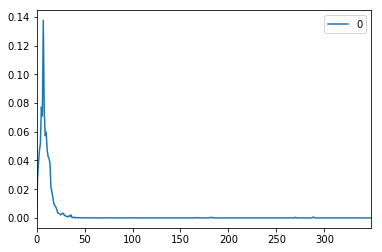

In [73]:
pd.DataFrame(a[:,1]).plot()

In [50]:
a[:,1].cumsum()

array([ 0.        ,  0.00349495,  0.00820224,  0.01239244,  0.01834819,
        0.02716344,  0.03539434,  0.0667754 ,  0.09496428,  0.1079498 ,
        0.12311329,  0.14080734,  0.15685048,  0.17740529,  0.19971567,
        0.2177885 ,  0.23457424,  0.25431543,  0.26922971,  0.2862036 ,
        0.30384657,  0.32017379,  0.33886836,  0.3532257 ,  0.3675793 ,
        0.38290476,  0.39761222,  0.41026133,  0.42411156,  0.43668591,
        0.45047883,  0.46229812,  0.47477778,  0.4863728 ,  0.49687884,
        0.50965629,  0.52154286,  0.53117797,  0.54126287,  0.55171035,
        0.56237587,  0.57152006,  0.58298052,  0.59337442,  0.6029684 ,
        0.61137872,  0.62077833,  0.63090934,  0.63904304,  0.64783462,
        0.65512356,  0.66338436,  0.67044653,  0.67817281,  0.68557388,
        0.69112469,  0.69740439,  0.70351215,  0.7077036 ,  0.71277595,
        0.71987799,  0.7252743 ,  0.73230408,  0.73575791,  0.74054245,
        0.74540174,  0.75165154,  0.75682731,  0.76148724,  0.76

In [51]:
X = all_matrix
y = np.zeros([X.shape[0], X.shape[1]],dtype='int32')
y[:,0] = X[:,0]>30 #超过20次访问（较高频的访问，占总访问量中10%视为异常）
y[:,1:] = X[:,1:]>0
X[:,1:] = X[:,1:]>0
print(y)
print(X)

[[0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 0]
 ..., 
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
[[ 2  0  0  0  0  0]
 [38  0  0  0  0  0]
 [10  0  0  0  0  0]
 ..., 
 [12  0  0  0  0  0]
 [ 3  0  0  0  0  0]
 [ 1  0  0  0  0  0]]


In [52]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X)

C:\Users\Casy\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [53]:
# 定义保存数据的类
import numpy as np

#定义类
class IPAccessInfo(object):
    def __init__(self, X, y, ip_dict, ip_reserve_list, data_scaler):
        self.X = X
        self.y = y
        self.ip_dict = ip_dict
        self.ip_reserve_list = ip_reserve_list
        self.data_scaler = data_scaler

In [55]:
# 保存文件为pkl
import pickle

iPAccessInfo = IPAccessInfo(X,y,ip_dict, ip_reserve_list, ss)
fp = open('iPAccessInfo1800per600.pkl','wb',True)
pickle.dump(iPAccessInfo, fp)